In [1]:
# nth attempt to generate ODE eqs (Von Neumann RHS) 
# given a hamiltonian. and eventually be able to make the RWA

In [126]:
import numpy as np
from sympy.parsing.sympy_parser import parse_expr
from sympy import MatrixSymbol,MatMul,Identity,I,Matrix,symbols,Function
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy.utilities.iterables import flatten
import sympy as sp
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [127]:
#### functions

def comm(A,B):
    """
    return commutator(A, B)[A,B]=A.B-B.A. Assumes symbolic matrix.
    """
    assert A.shape == B.shape, (f"A,B must have the same shape, but"+
                                f"A.shape={A.shape} != B.shape={B.shape}")
    return (MatMul(A,B)-MatMul(B,A)) #.as_mutable

In [181]:
def build_derivs(ham):
    """
    return derivatives function with call signature:
    derivs(y0, t) where y0 = [r11, r12, ...] 
    is the unraveled non-redundant density matrix
    
    'ham': a square sympy Matrix representing the full
        system Hamiltonian
    """
    assert ham.shape[0] == ham.shape[1], ("Hamiltonian"+
                                             " must be square, "+
                                             f"not of shape "+
                                              str(ham.shape))
    dims = ham.shape[0]
    # build a symbolic density matrix
    r = MatrixSymbol('r', dims, dims).as_mutable()
    for i in range(dims):
        for j in range(dims):
            r[i,j] = symbols(f'r{i}{j}')
            if i > j:
                r[i,j] = np.conj(r[j,i])
#     print(r) 

    # calculate [r, H]:
    rhs = comm(r, ham)
#     print("RHS eqs:")
#     for eq in rhs:
#         print(eq)

    # prune off non-redundant elements
    pruned_rhs = []
    for i in range(dim):
        for j in range(dim): 
            if i >= j:
                pruned_rhs.append(rhs[i,j])

    # wrap rhs in a function 
    args = list(rhs.free_symbols)
    args.sort(key=lambda x: x.__repr__())
#     args.append(symbols('t'))

    f = lambdify(args, pruned_rhs) # TODO: include t as argument
    print(help(f))

    # okay for time independent Hamiltonian, but need to work 
    # out for when H has explicit t dependence
    def derivs(t, y):  
        """A wrapper for the lambdagenerated function f"""
#         y.append(t)
        return f(*y)
    
    return derivs

In [183]:
# def foo(*args):
#     print(args, type(args))
    
# yargs = ['a', 'b', 'c']
# foo(*yargs) 

def bar(a, b, c, d):
    return [a, b, c, d]

xargs = [1, 2, 3, 4]   

bar(*xargs)

[1, 2, 3, 4]

In [184]:
#### here's how I want to call my RHS function

# define symbolic matrices which can be made numeric later
E1,E2,d,O = symbols('E1 E2 d O') # symbolic variables

# Set the parameters of H; arbitrary for now
E2 = 1 
E1 = 0
d = 1
O = 1 #TODO: rewrite this as a sympy function O(t)

# Declare the atom and interaction Hamiltonians
H_a = Matrix([[E1,0],[0,E2]])
H_field = Matrix([[0,-O/2],[-O/2,0]])
H = H_a + H_field # the full Hamiltonian

derivs = build_derivs(H)

Help on function _lambdifygenerated:

_lambdifygenerated(r00, r01, r11)
    Created with lambdify. Signature:
    
    func(r00, r01, r11)
    
    Expression:
    
    [-0.5*r01 + 0.5*conjugate(r01), 0.5*r00 - 0.5*r11 - conjugate(r01), 0.5*r01...
    
    Source code:
    
    def _lambdifygenerated(r00, r01, r11):
        return ([-0.5*r01 + 0.5*conjugate(r01), 0.5*r00 - 0.5*r11 - conjugate(r01), 0.5*r01 - 0.5*conjugate(r01)])
    
    
    Imported modules:

None


In [185]:
r0 = [1+0j, 0+0j, 0+0j]
derivs(0, r0)

[0j, (0.5+0j), 0j]

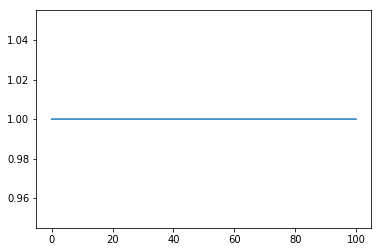

In [187]:
# try to plot the solution in time
r0 = [1+0j, 0+0j, 0+0j]
t_exp = 100
dt = 0.01
t_steps = np.arange(t_exp, step=dt)
soln = solve_ivp(derivs,[0,t_exp],r0,t_eval=t_steps)
plt.plot(soln.t,soln.y[0])